In [92]:
import numpy as np
import pandas as pd
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, f1_score
from matplotlib import pyplot as plt
from tqdm import tqdm



In [93]:
np.random.seed(200)

Base class

In [94]:
class baseModel:
    def forward(self, x):
        pass

    def backward(self, output, learning_rate):
        pass

### Convolution: There will be four (hyper)parameters:
1. Number of output channels
2. Filter dimension
3. Stride
4. Padding

### Important Links
#### Backward
1. [conv backward dx](https://medium.com/@mayank.utexas/backpropagation-for-convolution-with-strides-8137e4fc2710)
2. [conv backward dw, db](https://medium.com/@mayank.utexas/backpropagation-for-convolution-with-strides-fb2f2efc4faa)
3. [conv implement](https://github.com/slvrfn/vectorized_convolution/blob/master/convolution.py?fbclid=IwAR1SFj7zg2banabtjIWb9Rjrww1rjuGX4CZ7u8UHGIH3BJHnaSkMnhx2jdU)

In [95]:
# np.random.seed(69)

class ConvolutionLayer(baseModel):
    def __init__(self, output_channel, kernel_size, stride, padding):
        self.output_channel = output_channel
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weights = None
        self.bias = None
        self.x = None
        self.window_arr = None

    def forward(self, x):
        self.x = x # batch_size, channel, height, width
        batch_size, channel, height, width = x.shape
        output_height = (height - self.kernel_size + 2 * self.padding) // self.stride + 1
        output_width = (width - self.kernel_size + 2 * self.padding) // self.stride + 1
        self.output = np.zeros((batch_size, self.output_channel,  output_height, output_width))
        if self.weights is None:
            # init weight with Xavier method
            self.weights = np.random.randn(self.output_channel, channel, self.kernel_size, self.kernel_size) * np.sqrt(2 / (channel * self.kernel_size * self.kernel_size))
            self.bias = np.zeros(self.output_channel)
        
        # pad the input
        x_padded = np.pad(x, ((0,0), (0,0), (self.padding, self.padding), (self.padding, self.padding)), 'constant')

        window_arr = np.lib.stride_tricks.as_strided(x_padded, 
            shape=(batch_size, channel, output_height, output_width, self.kernel_size, self.kernel_size), 
            strides=(x_padded.strides[0], x_padded.strides[1], x_padded.strides[2]*self.stride, x_padded.strides[3]*self.stride, x_padded.strides[2], x_padded.strides[3]))

        self.window_arr = window_arr
        self.output = np.einsum('bihwkl,oikl->bohw', window_arr, self.weights) + self.bias[None, :, None, None]
        return self.output


    def backward(self, output, learning_rate):
        
        x = self.x
        window_arr = self.window_arr
        dilate = self.stride - 1
        # padding = self.kernel_size - 1 if self.padding == 0 else self.padding
        if self.padding == 0:
            padding = self.kernel_size - 1
        else:
            padding = self.padding
        working_input = output

        # dilate the input if needed
        if dilate != 0:
            working_input = np.insert(working_input, range(1, output.shape[2]), 0, axis=2)
            working_input = np.insert(working_input, range(1, output.shape[3]), 0, axis=3)

        # pad the input if needed
        if padding != 0:
            working_input = np.pad(working_input, ((0,0), (0,0), (padding, padding), (padding, padding)), 'constant')

        in_batch, in_channel, out_height, out_width = x.shape
        out_batch, out_channel, _, _ = output.shape
        stride = 1

        window_arr_out = np.lib.stride_tricks.as_strided(working_input,
            shape=(out_batch, out_channel, out_height, out_width, self.kernel_size, self.kernel_size),
            strides=(working_input.strides[0], working_input.strides[1], stride*working_input.strides[2], stride*working_input.strides[3], working_input.strides[2], working_input.strides[3]))

        rotated_kernel = np.rot90(self.weights, 2, axes=(2, 3))

        dx = np.einsum('bohwkl,oikl->bihw', window_arr_out, rotated_kernel)
        db = np.sum(output, axis=(0, 2, 3))
        dw = np.einsum('bihwkl,bohw->oikl', window_arr, output)
        
        self.weights -= learning_rate * dw
        self.bias -= learning_rate * db

        return dx   
        

In [96]:
count = 1*1*6*6
input_arr = np.arange(-count/2, count/2).reshape(1, 1, 6, 6)
print(f'input: {input_arr}\n')
conv_layer = ConvolutionLayer(1, 3, 1, 0)
print(conv_layer)
output = conv_layer.forward(input_arr)
print(output.shape)
print(f'output--------\n{output}\n')

input: [[[[-18. -17. -16. -15. -14. -13.]
   [-12. -11. -10.  -9.  -8.  -7.]
   [ -6.  -5.  -4.  -3.  -2.  -1.]
   [  0.   1.   2.   3.   4.   5.]
   [  6.   7.   8.   9.  10.  11.]
   [ 12.  13.  14.  15.  16.  17.]]]]

(1, 1, 4, 4)
output--------
[[[[-7.88349568 -7.49853119 -7.1135667  -6.72860221]
   [-5.57370875 -5.18874426 -4.80377977 -4.41881528]
   [-3.26392182 -2.87895733 -2.49399284 -2.10902836]
   [-0.95413489 -0.56917041 -0.18420592  0.20075857]]]]



### ReLU: 

In [97]:
class ReLULayer(baseModel):
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x
        return np.maximum(0, x)

    def backward(self, output, learning_rate):
        self.output = output
        return self.output * (self.x > 0)
        

In [98]:
relu_layer = ReLULayer()
output = relu_layer.forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 1, 4, 4)
output--------
[[[[0.         0.         0.         0.        ]
   [0.         0.         0.         0.        ]
   [0.         0.         0.         0.        ]
   [0.         0.         0.         0.20075857]]]]



### MaxPooling: There will be two parameters:
1. Filter dimension
2. Stride

### Important Links
#### Backward
1. [Maxpool Backward](https://stackoverflow.com/questions/61954727/max-pooling-backpropagation-using-numpy?fbclid=IwAR2PkO13F1_Jy99n5fysZD_dvHvqYQTPqno8Z-CLVt2-P664zjU1omJxMsQ)

In [99]:
class MaxPoolingLayer(baseModel):
    def __init__(self, pool_size, stride):
        self.pool_size = pool_size
        self.stride = stride
        self.x = None

    def forward(self, x):
        self.x = x
        batch_size, channel, height, width = x.shape
        output_height = (height - self.pool_size) // self.stride + 1
        output_width = (width - self.pool_size) // self.stride + 1
        self.output = np.zeros((batch_size, channel, output_height, output_width))
        
        # maxpooling without loop
        window_arr = np.lib.stride_tricks.as_strided(x, 
            shape=(batch_size, channel, output_height, output_width, self.pool_size, self.pool_size), 
            strides=(x.strides[0], x.strides[1], x.strides[2] * self.stride, x.strides[3] * self.stride, x.strides[2], x.strides[3]))
        self.output = np.max(window_arr, axis=(4, 5))
        return self.output

    def backward(self, output, learning_rate):
        x = self.x
        batch_size, channel, height, width = x.shape
        out_batch, out_channel, out_height, out_width = output.shape

        dx = np.zeros(shape=x.shape)

        for i in range(batch_size):
            for j in range(channel):
                for k in range(out_height):
                    for l in range(out_width):
                        # index i,j with maximum vakue
                        i_t, j_t = np.where(np.max(x[i, j, k * self.stride : k * self.stride + self.pool_size, l * self.stride : l * self.stride + self.pool_size]) == x[i, j, k * self.stride : k * self.stride + self.pool_size, l * self.stride : l * self.stride + self.pool_size])
                        i_t, j_t = i_t[0], j_t[0]
                        # print(i_t, j_t)
                        # i,j index gets value from output 
                        dx[i, j, k * self.stride : k * self.stride + self.pool_size, l * self.stride : l * self.stride + self.pool_size][i_t, j_t] = output[i, j, k, l]
        return dx
        

In [100]:
maxpool_layer = MaxPoolingLayer(2, 1)   
output = maxpool_layer.forward(output)

print(output.shape)
print(f'output--------\n{output}\n')

output_rev = maxpool_layer.backward(output, 0.1)
print(output_rev.shape)
print(f'output--------\n{output_rev}\n')

(1, 1, 3, 3)
output--------
[[[[0.         0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.20075857]]]]

(1, 1, 4, 4)
output--------
[[[[0.         0.         0.         0.        ]
   [0.         0.         0.         0.        ]
   [0.         0.         0.         0.        ]
   [0.         0.         0.         0.20075857]]]]



### Flattening: 

In [101]:
class FlatteningLayer(baseModel):
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x
        batch_size, channel, height, width = x.shape
        self.output = x.reshape((batch_size, channel * height * width))
        return self.output

    def backward(self, output, learning_rate):
        dx = output.reshape(self.x.shape)
        return dx

In [102]:
flat_layer = FlatteningLayer()
output = flat_layer.forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 9)
output--------
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.20075857]]



### Fully-connected layer: a dense layer. There will be one paramete:
1. Output dimension

In [103]:
class FullyConnectedLayer(baseModel):
    def __init__(self, output_channel):
        self.output_channel = output_channel
        self.weights = None
        self.bias = None
        self.x = None
        

    def forward(self, x):
        self.x = x

        # print(f'fully connected layer input: {self.x}' )

        if self.weights is None:
            self.weights = np.random.randn(self.x.shape[1], self.output_channel) * np.sqrt(2 / self.x.shape[1])
            self.bias = np.zeros(self.output_channel)
            
        self.output = np.dot(self.x, self.weights) + self.bias

        # print(f'fully connected layer output: {self.output}' )
        return self.output

    def backward(self, output, learning_rate):
        self.output = output
        self.learning_rate = learning_rate

        dw = np.dot(self.x.T, self.output)
        db = np.sum(self.output, axis=0)
        dx = np.dot(self.output, self.weights.T)

        self.weights -= self.learning_rate * dw 
        self.bias -= self.learning_rate * db
        
        return dx

In [104]:
fullConn_layer = FullyConnectedLayer(10)
output = fullConn_layer.forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 10)
output--------
[[-0.1550242  -0.0143143   0.08587914  0.00637811  0.06534712 -0.00662171
   0.07072514 -0.02899951  0.01722336 -0.00682685]]



### Softmax: it will convert final layer projections to normalized probabilities

In [105]:
class SoftmaxLayer(baseModel):
    def __init__(self):
        self.x = None

    def forward(self, x):
        self.x = x
        
        # normalize input
        x -= np.max(x, axis=1, keepdims=True)
        x_exp = np.exp(x)
        sum_exp = np.sum(x_exp, axis=1, keepdims=True)
        sum_exp[ sum_exp == 0] = 1
        self.output = x_exp / sum_exp

        # print(f'softmax layer output: {self.output}' )
        return self.output

    def backward(self, output, learning_rate):
        return output

In [106]:
softmax_layer = SoftmaxLayer()
output = softmax_layer.forward(output)
print(output.shape)
print(f'output--------\n{output}\n')

(1, 10)
output--------
[[0.0851756  0.09804484 0.10837727 0.10009476 0.10617476 0.09880197
  0.1067473  0.09661555 0.10118622 0.09878171]]



### Create Model

In [107]:
def createModel():
    model = []
    
    model.append(ConvolutionLayer(6, 5, 1, 0))
    model.append(ReLULayer())
    model.append(MaxPoolingLayer(2, 2))
    model.append(ConvolutionLayer(16, 5, 1, 0))
    model.append(ReLULayer())
    model.append(MaxPoolingLayer(2, 2))
    model.append(FlatteningLayer())
    model.append(FullyConnectedLayer(120))
    model.append(ReLULayer())
    model.append(FullyConnectedLayer(84))
    model.append(ReLULayer())
    model.append(FullyConnectedLayer(10))
    model.append(SoftmaxLayer())
    print('model created: ', model)
    return model

In [108]:
# get images
def getImages(path,cnt):
    images = []
    count = 0

    path_split = path.split('.')
    new_path = path_split[0]
    df = pd.read_csv(path)
    files = df['filename']
    
    for file in files:
        if count == cnt:
            break
        img = cv2.imread(os.path.join(new_path, file))
        img = cv2.resize(img, (28, 28))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = (255-img.transpose(2, 0, 1))/255
        images.append(img)
        count += 1

    return images

In [109]:
# get labels
def getLabels(path,cnt):
    labels = []
    count = cnt
    
    df = pd.read_csv(path)
    print(len(df))
    if count >= len(df):
        count = len(df)
    labels = df['digit'][:count]
    return np.array(labels)

In [110]:
# train
def train(model, X_train, X_test, Y_train, Y_test, learning_rate, epochs):
    batch_size = 32

    # init metrics array
    train_loss_arr = []
    train_accuracy_arr = []
    val_loss_arr = []
    val_accuracy_arr = []
    val_macroF1_arr = []

    for epoch in range(epochs):
        print(f'epoch: {epoch+1}/{epochs}')
        num_batches = X_train.shape[0] // batch_size
        loss = 0
        accuracy = 0
        for i in tqdm(range(num_batches)):
            # forward
            x_batch = X_train[i*batch_size: (i+1)*batch_size]
            y_output = Y_train[i*batch_size: (i+1)*batch_size]

            x_output = x_batch
            for layer in model:
                x_output = layer.forward(x_output)
            
            #loss
            loss += log_loss(y_output, x_output)
            accuracy += accuracy_score(np.argmax(y_output, axis=1), np.argmax(x_output, axis=1))

            dL = np.copy(x_output)
            dL -= y_output
            dL /= batch_size
            # backward
            for layer in reversed(model):
                dL = layer.backward(dL, learning_rate)
        
        #train loss and accuracy
        train_loss = loss/num_batches
        train_accuracy = accuracy/num_batches

        train_loss_arr.append(train_loss)
        train_accuracy_arr.append(train_accuracy)

        # test
        val_loss = 0
        
        x_out = X_test
        for layer in model:
            x_out = layer.forward(x_out)

        
        val_loss = log_loss(Y_test, x_out)
        val_accuracy = accuracy_score(np.argmax(Y_test, axis=1), np.argmax(x_out, axis=1))
        val_F1 = f1_score(np.argmax(Y_test, axis=1), np.argmax(x_out, axis=1), average='macro')

        val_loss_arr.append(val_loss)
        val_accuracy_arr.append(val_accuracy)
        val_macroF1_arr.append(val_F1)

        print(f'loss: {train_loss}, val_loss: {val_loss}')
        print(f'accuracy: {train_accuracy}, val_accuracy: {val_accuracy}')
        print(f'val_F1: {val_F1}')

    return train_loss_arr, val_loss_arr, val_accuracy_arr, val_macroF1_arr

        
        



In [121]:

def load_data():
    count = 2500
    images = getImages('data/training-a.csv', count)
    images += getImages('data/training-b.csv', count)
    images += getImages('data/training-c.csv', count)

    labels = getLabels('data/training-a.csv', count)
    labels = np.concatenate((labels, getLabels('data/training-b.csv', count)))
    labels = np.concatenate((labels, getLabels('data/training-c.csv', count)))

    # one hot encode
    labels = np.eye(10)[labels].astype(int)

    print(len(images))
    print(images[0].shape)
    print(labels.shape)
    # # view an image
    # plt.imshow(images[1].transpose(1, 2, 0))
    # print(labels[1])

    return images, labels


In [112]:
# initialize model
model = createModel()

model created:  [<__main__.ConvolutionLayer object at 0x7fb3d6e20d90>, <__main__.ReLULayer object at 0x7fb3d6e20eb0>, <__main__.MaxPoolingLayer object at 0x7fb3d6e20ca0>, <__main__.ConvolutionLayer object at 0x7fb3d6e0d0d0>, <__main__.ReLULayer object at 0x7fb3d6e0d7c0>, <__main__.MaxPoolingLayer object at 0x7fb3d6e0da60>, <__main__.FlatteningLayer object at 0x7fb3d6e0da30>, <__main__.FullyConnectedLayer object at 0x7fb3d6ba4b20>, <__main__.ReLULayer object at 0x7fb3d6a3f5b0>, <__main__.FullyConnectedLayer object at 0x7fb3d6a3f670>, <__main__.ReLULayer object at 0x7fb3d6d77730>, <__main__.FullyConnectedLayer object at 0x7fb3d6d77fa0>, <__main__.SoftmaxLayer object at 0x7fb3d6d77f10>]


In [113]:
# train model

images, labels = load_data()

X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train = np.array(X_train)
X_test = np.array(X_test)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


19702
359
24298
5359
(3, 28, 28)
(5359, 10)
(4287, 3, 28, 28)
(1072, 3, 28, 28)
(4287, 10)
(1072, 10)


In [114]:

epochs = 100
train_loss_arr, val_loss_arr, val_accuracy_arr, val_macroF1_arr = train(model, X_train, X_test, Y_train, Y_test, 0.001, epochs)

epoch: 1/100


100%|██████████| 133/133 [02:57<00:00,  1.33s/it]


loss: 2.344247856033156, val_loss: 2.3168964687794738
accuracy: 0.09515977443609022, val_accuracy: 0.11940298507462686
val_F1: 0.09946675824017402
epoch: 2/100


100%|██████████| 133/133 [02:37<00:00,  1.19s/it]


loss: 2.3210932331184346, val_loss: 2.3049961473095752
accuracy: 0.10549812030075188, val_accuracy: 0.12406716417910447
val_F1: 0.11407120910595892
epoch: 3/100


100%|██████████| 133/133 [02:06<00:00,  1.06it/s]


loss: 2.3079729153068635, val_loss: 2.2967726180253263
accuracy: 0.10925751879699248, val_accuracy: 0.1333955223880597
val_F1: 0.1255195664075051
epoch: 4/100


100%|██████████| 133/133 [01:55<00:00,  1.15it/s]


loss: 2.298530430719001, val_loss: 2.2902303295663318
accuracy: 0.11536654135338346, val_accuracy: 0.1455223880597015
val_F1: 0.1366535405502564
epoch: 5/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 2.2905982606958326, val_loss: 2.2840191196046526
accuracy: 0.12899436090225563, val_accuracy: 0.15578358208955223
val_F1: 0.14689601267898392
epoch: 6/100


100%|██████████| 133/133 [01:57<00:00,  1.13it/s]


loss: 2.2836077197942726, val_loss: 2.2782594148277786
accuracy: 0.14144736842105263, val_accuracy: 0.1669776119402985
val_F1: 0.15869626320240918
epoch: 7/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 2.2771829952161964, val_loss: 2.2728140874271108
accuracy: 0.14967105263157895, val_accuracy: 0.16791044776119404
val_F1: 0.16134991823645273
epoch: 8/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 2.2710909364832994, val_loss: 2.2673675636666517
accuracy: 0.16141917293233082, val_accuracy: 0.18190298507462688
val_F1: 0.17561538582848585
epoch: 9/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 2.2651006307662622, val_loss: 2.2618475678525174
accuracy: 0.17105263157894737, val_accuracy: 0.19682835820895522
val_F1: 0.19115329200130587
epoch: 10/100


100%|██████████| 133/133 [01:59<00:00,  1.11it/s]


loss: 2.2591714691832125, val_loss: 2.2561593316035613
accuracy: 0.18280075187969924, val_accuracy: 0.2080223880597015
val_F1: 0.19944031213602348
epoch: 11/100


100%|██████████| 133/133 [02:04<00:00,  1.07it/s]


loss: 2.25320819152106, val_loss: 2.2503396889189418
accuracy: 0.19266917293233082, val_accuracy: 0.20708955223880596
val_F1: 0.19564584532435475
epoch: 12/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 2.2470430566904236, val_loss: 2.2441899792350966
accuracy: 0.20347744360902256, val_accuracy: 0.21361940298507462
val_F1: 0.2005357244875044
epoch: 13/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 2.2405056845859157, val_loss: 2.237674159005106
accuracy: 0.212406015037594, val_accuracy: 0.22108208955223882
val_F1: 0.2035901462562119
epoch: 14/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 2.2336586081095233, val_loss: 2.23077383390793
accuracy: 0.22227443609022557, val_accuracy: 0.23041044776119404
val_F1: 0.20926967007817251
epoch: 15/100


100%|██████████| 133/133 [02:08<00:00,  1.03it/s]


loss: 2.2263833175881804, val_loss: 2.223413881053583
accuracy: 0.23284774436090225, val_accuracy: 0.23787313432835822
val_F1: 0.21428387400623383
epoch: 16/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 2.2187334903623324, val_loss: 2.2155941499846348
accuracy: 0.243656015037594, val_accuracy: 0.24720149253731344
val_F1: 0.22273326847367386
epoch: 17/100


100%|██████████| 133/133 [02:05<00:00,  1.06it/s]


loss: 2.21053713312233, val_loss: 2.2070710052742726
accuracy: 0.2523496240601504, val_accuracy: 0.2537313432835821
val_F1: 0.2279712635192514
epoch: 18/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 2.201828770083234, val_loss: 2.1978233312951625
accuracy: 0.25775375939849626, val_accuracy: 0.2667910447761194
val_F1: 0.23907060834955782
epoch: 19/100


100%|██████████| 133/133 [02:07<00:00,  1.05it/s]


loss: 2.1925158221698027, val_loss: 2.187768341985228
accuracy: 0.2631578947368421, val_accuracy: 0.27705223880597013
val_F1: 0.24694601150666995
epoch: 20/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 2.182441874562215, val_loss: 2.1769472248231914
accuracy: 0.268562030075188, val_accuracy: 0.2835820895522388
val_F1: 0.2486462123657099
epoch: 21/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 2.1716143109493595, val_loss: 2.165467078151302
accuracy: 0.27326127819548873, val_accuracy: 0.292910447761194
val_F1: 0.2571598284302673
epoch: 22/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 2.1600957043381004, val_loss: 2.153292719004044
accuracy: 0.2800751879699248, val_accuracy: 0.2994402985074627
val_F1: 0.264217224374908
epoch: 23/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 2.147772403430075, val_loss: 2.140330096834955
accuracy: 0.28406954887218044, val_accuracy: 0.30223880597014924
val_F1: 0.26468808441003844
epoch: 24/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 2.1348149614228733, val_loss: 2.1266339488931005
accuracy: 0.2932330827067669, val_accuracy: 0.3041044776119403
val_F1: 0.26628725918868124
epoch: 25/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 2.1211611716332963, val_loss: 2.1120121890318124
accuracy: 0.29887218045112784, val_accuracy: 0.30783582089552236
val_F1: 0.2696633726330595
epoch: 26/100


100%|██████████| 133/133 [02:08<00:00,  1.04it/s]


loss: 2.1067457994118928, val_loss: 2.09682977526839
accuracy: 0.3073308270676692, val_accuracy: 0.314365671641791
val_F1: 0.2765577840140489
epoch: 27/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 2.091677883580335, val_loss: 2.081072574417979
accuracy: 0.31414473684210525, val_accuracy: 0.3218283582089552
val_F1: 0.28331274804270895
epoch: 28/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 2.0760803805423134, val_loss: 2.0648754884102227
accuracy: 0.3193139097744361, val_accuracy: 0.3302238805970149
val_F1: 0.293130423623181
epoch: 29/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 2.0599751003682676, val_loss: 2.048213877286374
accuracy: 0.32706766917293234, val_accuracy: 0.3423507462686567
val_F1: 0.3079729146805703
epoch: 30/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 2.0435247055455847, val_loss: 2.031259518159156
accuracy: 0.33153195488721804, val_accuracy: 0.35261194029850745
val_F1: 0.3214723196089383
epoch: 31/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 2.0266987458324484, val_loss: 2.013769080945371
accuracy: 0.33670112781954886, val_accuracy: 0.3591417910447761
val_F1: 0.3282294905027221
epoch: 32/100


100%|██████████| 133/133 [02:07<00:00,  1.05it/s]


loss: 2.009550360318, val_loss: 1.9961464593750304
accuracy: 0.3456296992481203, val_accuracy: 0.3628731343283582
val_F1: 0.3324254813341715
epoch: 33/100


100%|██████████| 133/133 [02:07<00:00,  1.05it/s]


loss: 1.9920884641127106, val_loss: 1.9786286922943213
accuracy: 0.3533834586466165, val_accuracy: 0.3712686567164179
val_F1: 0.3438109270202375
epoch: 34/100


100%|██████████| 133/133 [02:08<00:00,  1.04it/s]


loss: 1.9748576896988055, val_loss: 1.9611276322875455
accuracy: 0.35972744360902253, val_accuracy: 0.37779850746268656
val_F1: 0.3507773688311467
epoch: 35/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 1.9578219664985204, val_loss: 1.9439323576985388
accuracy: 0.36771616541353386, val_accuracy: 0.3871268656716418
val_F1: 0.3617338596289418
epoch: 36/100


100%|██████████| 133/133 [02:07<00:00,  1.05it/s]


loss: 1.9407581925338353, val_loss: 1.9268071977634538
accuracy: 0.37359022556390975, val_accuracy: 0.394589552238806
val_F1: 0.37092461900953955
epoch: 37/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.9239398519310786, val_loss: 1.909927852602271
accuracy: 0.3801691729323308, val_accuracy: 0.4039179104477612
val_F1: 0.38186327302696155
epoch: 38/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.9071638288842665, val_loss: 1.8931399589071427
accuracy: 0.3879229323308271, val_accuracy: 0.41138059701492535
val_F1: 0.39121405273054644
epoch: 39/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.890516144829573, val_loss: 1.8768285612970994
accuracy: 0.3942669172932331, val_accuracy: 0.41697761194029853
val_F1: 0.39725550804598
epoch: 40/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.874056681214836, val_loss: 1.860751276857
accuracy: 0.39896616541353386, val_accuracy: 0.4253731343283582
val_F1: 0.4075137327518018
epoch: 41/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.8577358393475218, val_loss: 1.8449198085550214
accuracy: 0.40249060150375937, val_accuracy: 0.43283582089552236
val_F1: 0.41646532202272796
epoch: 42/100


100%|██████████| 133/133 [02:08<00:00,  1.04it/s]


loss: 1.841400081316994, val_loss: 1.82912357946672
accuracy: 0.40671992481203006, val_accuracy: 0.43656716417910446
val_F1: 0.4197466103596083
epoch: 43/100


100%|██████████| 133/133 [02:06<00:00,  1.06it/s]


loss: 1.8250311764879654, val_loss: 1.8133279196390582
accuracy: 0.4118890977443609, val_accuracy: 0.4412313432835821
val_F1: 0.42521313477251804
epoch: 44/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.8086918788007236, val_loss: 1.797698579338392
accuracy: 0.4168233082706767, val_accuracy: 0.4449626865671642
val_F1: 0.42929086035128056
epoch: 45/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.7924931762862846, val_loss: 1.7818945877753216
accuracy: 0.4243421052631579, val_accuracy: 0.4533582089552239
val_F1: 0.4383791401540874
epoch: 46/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 1.7762502846009407, val_loss: 1.7660196176483667
accuracy: 0.42974624060150374, val_accuracy: 0.45988805970149255
val_F1: 0.44614612498384154
epoch: 47/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 1.7600487529597801, val_loss: 1.7502141646110299
accuracy: 0.43726503759398494, val_accuracy: 0.46828358208955223
val_F1: 0.45617642642293144
epoch: 48/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 1.7438643798958968, val_loss: 1.7347786244960917
accuracy: 0.4440789473684211, val_accuracy: 0.4710820895522388
val_F1: 0.45923207208020234
epoch: 49/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.7277584354089954, val_loss: 1.7195805861812725
accuracy: 0.4483082706766917, val_accuracy: 0.478544776119403
val_F1: 0.4667514465558521
epoch: 50/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 1.711444032631147, val_loss: 1.7043532187614578
accuracy: 0.456062030075188, val_accuracy: 0.4832089552238806
val_F1: 0.4718253343110084
epoch: 51/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 1.6949781879661372, val_loss: 1.6894990419241218
accuracy: 0.4621710526315789, val_accuracy: 0.48880597014925375
val_F1: 0.4775866477663643
epoch: 52/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 1.6784833044938998, val_loss: 1.6744255795696785
accuracy: 0.46710526315789475, val_accuracy: 0.4925373134328358
val_F1: 0.4814788244728999
epoch: 53/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 1.6621784297965134, val_loss: 1.6594397256886766
accuracy: 0.4739191729323308, val_accuracy: 0.4916044776119403
val_F1: 0.48052716968702525
epoch: 54/100


100%|██████████| 133/133 [02:08<00:00,  1.04it/s]


loss: 1.6458663231983122, val_loss: 1.6446924260299913
accuracy: 0.48002819548872183, val_accuracy: 0.498134328358209
val_F1: 0.48804355203443645
epoch: 55/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 1.629729786705181, val_loss: 1.6300170382829493
accuracy: 0.4856672932330827, val_accuracy: 0.5
val_F1: 0.4904750490916962
epoch: 56/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.6139135109169, val_loss: 1.615559118199172
accuracy: 0.49154135338345867, val_accuracy: 0.5046641791044776
val_F1: 0.49499357817301676
epoch: 57/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.5983674773895296, val_loss: 1.6015866553213576
accuracy: 0.49741541353383456, val_accuracy: 0.5074626865671642
val_F1: 0.49765831736149313
epoch: 58/100


100%|██████████| 133/133 [02:07<00:00,  1.05it/s]


loss: 1.5829103497631052, val_loss: 1.5878299369103885
accuracy: 0.5028195488721805, val_accuracy: 0.5027985074626866
val_F1: 0.4922666907495955
epoch: 59/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.5676177648614311, val_loss: 1.5742715474948594
accuracy: 0.506109022556391, val_accuracy: 0.5093283582089553
val_F1: 0.4989823947264142
epoch: 60/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 1.5524368748946435, val_loss: 1.5608199926593835
accuracy: 0.5117481203007519, val_accuracy: 0.5121268656716418
val_F1: 0.5021066048993136
epoch: 61/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.5373154792255797, val_loss: 1.5474679623967402
accuracy: 0.518796992481203, val_accuracy: 0.5149253731343284
val_F1: 0.5046610436818983
epoch: 62/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.522249116191138, val_loss: 1.5337866602014059
accuracy: 0.5242011278195489, val_accuracy: 0.5186567164179104
val_F1: 0.509168591861055
epoch: 63/100


100%|██████████| 133/133 [02:07<00:00,  1.05it/s]


loss: 1.507357973650172, val_loss: 1.5201855604000094
accuracy: 0.5272556390977443, val_accuracy: 0.5214552238805971
val_F1: 0.5118154333555692
epoch: 64/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.4926608329168098, val_loss: 1.5069800157642177
accuracy: 0.5307800751879699, val_accuracy: 0.5214552238805971
val_F1: 0.5117431134496744
epoch: 65/100


100%|██████████| 133/133 [02:07<00:00,  1.05it/s]


loss: 1.47818473702895, val_loss: 1.493581148691699
accuracy: 0.5364191729323309, val_accuracy: 0.5289179104477612
val_F1: 0.5192447060316299
epoch: 66/100


100%|██████████| 133/133 [02:05<00:00,  1.06it/s]


loss: 1.4638475428813171, val_loss: 1.4801294160367091
accuracy: 0.5390037593984962, val_accuracy: 0.5307835820895522
val_F1: 0.5219523030246294
epoch: 67/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 1.4496304553737938, val_loss: 1.4670221354469182
accuracy: 0.5427631578947368, val_accuracy: 0.5373134328358209
val_F1: 0.5288623563423349
epoch: 68/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.4355134594115317, val_loss: 1.4538649738991802
accuracy: 0.5467575187969925, val_accuracy: 0.5401119402985075
val_F1: 0.5316466905602985
epoch: 69/100


100%|██████████| 133/133 [02:07<00:00,  1.05it/s]


loss: 1.4216069552994655, val_loss: 1.4411853896266842
accuracy: 0.5531015037593985, val_accuracy: 0.5419776119402985
val_F1: 0.5335445756672226
epoch: 70/100


100%|██████████| 133/133 [02:07<00:00,  1.04it/s]


loss: 1.407815635284571, val_loss: 1.4283485322847487
accuracy: 0.5578007518796992, val_accuracy: 0.5447761194029851
val_F1: 0.5364032130727819
epoch: 71/100


100%|██████████| 133/133 [02:06<00:00,  1.05it/s]


loss: 1.394145330032921, val_loss: 1.4155358944779601
accuracy: 0.5601503759398496, val_accuracy: 0.5466417910447762
val_F1: 0.5384520300338071
epoch: 72/100


100%|██████████| 133/133 [01:57<00:00,  1.14it/s]


loss: 1.3805480135317174, val_loss: 1.4029404195691848
accuracy: 0.5667293233082706, val_accuracy: 0.5485074626865671
val_F1: 0.5408664186361493
epoch: 73/100


100%|██████████| 133/133 [01:21<00:00,  1.63it/s]


loss: 1.3671577726577262, val_loss: 1.391115667472959
accuracy: 0.5709586466165414, val_accuracy: 0.5522388059701493
val_F1: 0.5441215304696481
epoch: 74/100


100%|██████████| 133/133 [01:23<00:00,  1.60it/s]


loss: 1.3539526978858276, val_loss: 1.379278691576687
accuracy: 0.5747180451127819, val_accuracy: 0.5541044776119403
val_F1: 0.5462079145149525
epoch: 75/100


100%|██████████| 133/133 [01:27<00:00,  1.51it/s]


loss: 1.3409644416700526, val_loss: 1.3669685590299177
accuracy: 0.5796522556390977, val_accuracy: 0.5559701492537313
val_F1: 0.5474214545605889
epoch: 76/100


100%|██████████| 133/133 [01:27<00:00,  1.52it/s]


loss: 1.328162746990622, val_loss: 1.3554829034342344
accuracy: 0.5836466165413534, val_accuracy: 0.5578358208955224
val_F1: 0.5493911603554252
epoch: 77/100


100%|██████████| 133/133 [01:29<00:00,  1.49it/s]


loss: 1.3154689838980897, val_loss: 1.3434606432853358
accuracy: 0.5869360902255639, val_accuracy: 0.5606343283582089
val_F1: 0.552107092691124
epoch: 78/100


100%|██████████| 133/133 [01:27<00:00,  1.52it/s]


loss: 1.3028865204942597, val_loss: 1.3319900643307196
accuracy: 0.5916353383458647, val_accuracy: 0.5625
val_F1: 0.5537297836884043
epoch: 79/100


100%|██████████| 133/133 [01:28<00:00,  1.50it/s]


loss: 1.2905371998271, val_loss: 1.320789108698119
accuracy: 0.5935150375939849, val_accuracy: 0.5652985074626866
val_F1: 0.5569854663505862
epoch: 80/100


100%|██████████| 133/133 [01:28<00:00,  1.51it/s]


loss: 1.2782620568362661, val_loss: 1.3099756787893964
accuracy: 0.5977443609022557, val_accuracy: 0.5671641791044776
val_F1: 0.5589682012115887
epoch: 81/100


100%|██████████| 133/133 [01:28<00:00,  1.49it/s]


loss: 1.2660404563166054, val_loss: 1.2994634581589093
accuracy: 0.6007988721804511, val_accuracy: 0.5680970149253731
val_F1: 0.5599893709668722
epoch: 82/100


100%|██████████| 133/133 [01:27<00:00,  1.51it/s]


loss: 1.2538018504752946, val_loss: 1.288771839535484
accuracy: 0.6040883458646616, val_accuracy: 0.5727611940298507
val_F1: 0.5643613832804133
epoch: 83/100


100%|██████████| 133/133 [01:28<00:00,  1.50it/s]


loss: 1.2419812489455475, val_loss: 1.2780071065870584
accuracy: 0.6090225563909775, val_accuracy: 0.5736940298507462
val_F1: 0.565361751440274
epoch: 84/100


100%|██████████| 133/133 [01:27<00:00,  1.52it/s]


loss: 1.2301120235723613, val_loss: 1.2676502403072119
accuracy: 0.612312030075188, val_accuracy: 0.5746268656716418
val_F1: 0.5660550853459541
epoch: 85/100


100%|██████████| 133/133 [01:29<00:00,  1.48it/s]


loss: 1.2185127089060404, val_loss: 1.2578275352892643
accuracy: 0.6167763157894737, val_accuracy: 0.5727611940298507
val_F1: 0.5638074080241221
epoch: 86/100


100%|██████████| 133/133 [01:27<00:00,  1.52it/s]


loss: 1.2071819669702273, val_loss: 1.2475102471395516
accuracy: 0.6193609022556391, val_accuracy: 0.582089552238806
val_F1: 0.5734711892331362
epoch: 87/100


100%|██████████| 133/133 [01:29<00:00,  1.49it/s]


loss: 1.1959371387684128, val_loss: 1.237379174296553
accuracy: 0.6212406015037594, val_accuracy: 0.5867537313432836
val_F1: 0.5779460399503876
epoch: 88/100


100%|██████████| 133/133 [01:30<00:00,  1.46it/s]


loss: 1.1849166724502649, val_loss: 1.2272880636549581
accuracy: 0.6238251879699248, val_accuracy: 0.5942164179104478
val_F1: 0.5849840099353665
epoch: 89/100


100%|██████████| 133/133 [01:30<00:00,  1.48it/s]


loss: 1.1741118581195542, val_loss: 1.2170436859551452
accuracy: 0.6261748120300752, val_accuracy: 0.5932835820895522
val_F1: 0.5840698421557011
epoch: 90/100


100%|██████████| 133/133 [01:28<00:00,  1.51it/s]


loss: 1.1632581415654988, val_loss: 1.2073340413363653
accuracy: 0.6304041353383458, val_accuracy: 0.5979477611940298
val_F1: 0.5887085049702983
epoch: 91/100


100%|██████████| 133/133 [01:33<00:00,  1.43it/s]


loss: 1.1527205243555585, val_loss: 1.197881071548974
accuracy: 0.6346334586466166, val_accuracy: 0.601679104477612
val_F1: 0.5925404960376179
epoch: 92/100


100%|██████████| 133/133 [01:40<00:00,  1.32it/s]


loss: 1.1422899499759915, val_loss: 1.1879794868509161
accuracy: 0.6386278195488722, val_accuracy: 0.6035447761194029
val_F1: 0.5942956466549626
epoch: 93/100


100%|██████████| 133/133 [01:28<00:00,  1.50it/s]


loss: 1.131973833241048, val_loss: 1.1787622762359742
accuracy: 0.6414473684210527, val_accuracy: 0.6035447761194029
val_F1: 0.5937657449472983
epoch: 94/100


100%|██████████| 133/133 [01:28<00:00,  1.51it/s]


loss: 1.1216394623575416, val_loss: 1.1690406374232543
accuracy: 0.6440319548872181, val_accuracy: 0.6082089552238806
val_F1: 0.5991114804014508
epoch: 95/100


100%|██████████| 133/133 [01:27<00:00,  1.51it/s]


loss: 1.1115187710479348, val_loss: 1.1595230178600473
accuracy: 0.6484962406015038, val_accuracy: 0.6110074626865671
val_F1: 0.6018163571084629
epoch: 96/100


100%|██████████| 133/133 [01:28<00:00,  1.50it/s]


loss: 1.1015174062216837, val_loss: 1.1504043811294382
accuracy: 0.6524906015037594, val_accuracy: 0.6184701492537313
val_F1: 0.6089012895723048
epoch: 97/100


100%|██████████| 133/133 [01:28<00:00,  1.51it/s]


loss: 1.091827968378766, val_loss: 1.1410024845669546
accuracy: 0.6560150375939849, val_accuracy: 0.621268656716418
val_F1: 0.6121264548914775
epoch: 98/100


100%|██████████| 133/133 [01:28<00:00,  1.51it/s]


loss: 1.0820292367564421, val_loss: 1.1319630300196704
accuracy: 0.6574248120300752, val_accuracy: 0.6231343283582089
val_F1: 0.6143392464701469
epoch: 99/100


100%|██████████| 133/133 [01:28<00:00,  1.51it/s]


loss: 1.0723753465592072, val_loss: 1.1233887012933845
accuracy: 0.6590695488721805, val_accuracy: 0.6259328358208955
val_F1: 0.6171454773528998
epoch: 100/100


100%|██████████| 133/133 [01:28<00:00,  1.51it/s]


loss: 1.0628671882766931, val_loss: 1.1142181700855993
accuracy: 0.6604793233082706, val_accuracy: 0.628731343283582
val_F1: 0.6205116877251897


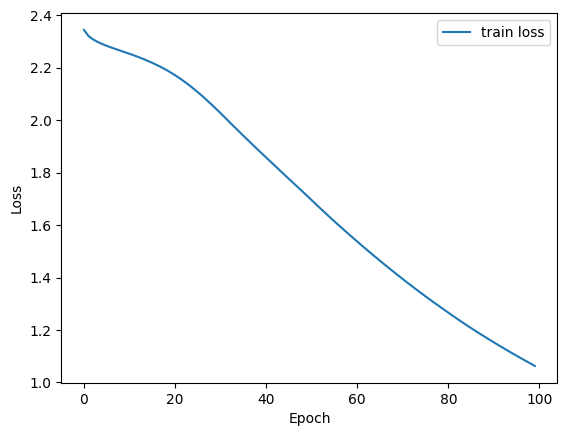

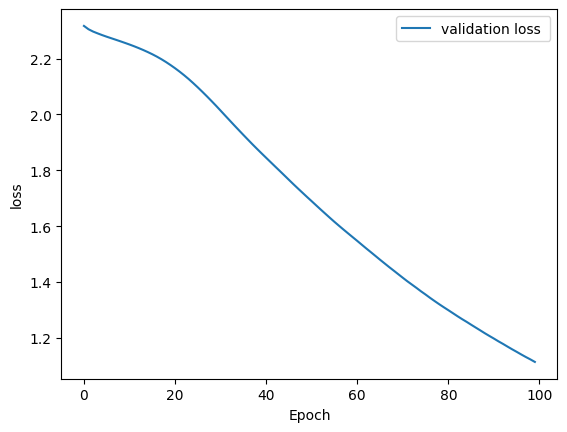

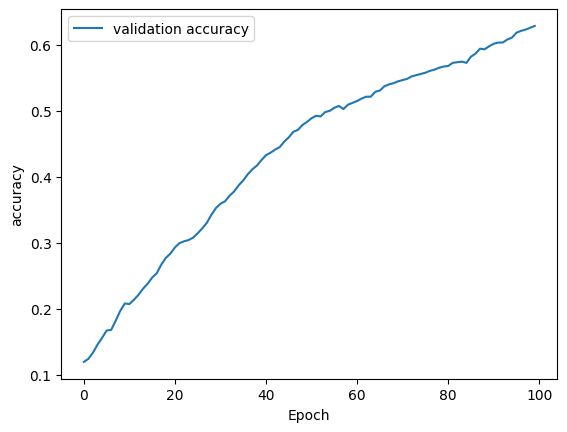

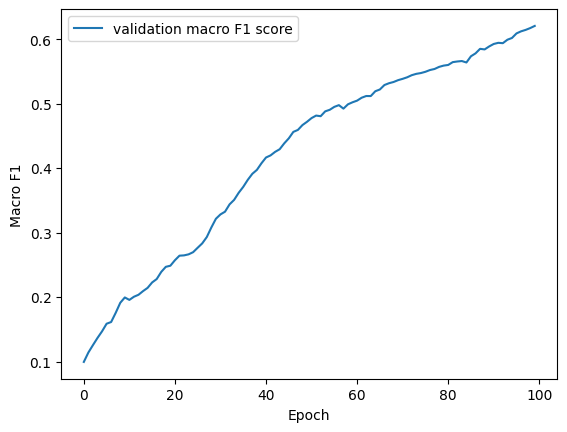

In [115]:


plt.plot(train_loss_arr, label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# show train, validation accuracy
plt.plot(val_loss_arr, label='validation loss ')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


plt.plot(val_accuracy_arr, label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(val_macroF1_arr, label='validation macro F1 score')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.legend()
plt.show()


In [123]:
def load_test_data():
    count = 10000
    images = getImages('data/training-d.csv', count)

    labels = getLabels('data/training-d.csv', count)

    # one hot encode
    labels = np.eye(10)[labels].astype(int)

    print(len(images))
    print(images[0].shape)
    print(labels.shape)
    # # view an image
    # plt.imshow(images[1].transpose(1, 2, 0))
    # print(labels[1])

    return images, labels

In [125]:
def test(model, X_test, Y_test):
    x_out = X_test
    for layer in model:
        x_out = layer.forward(x_out)

    val_accuracy = accuracy_score(np.argmax(Y_test, axis=1), np.argmax(x_out, axis=1))
    val_F1 = f1_score(np.argmax(Y_test, axis=1), np.argmax(x_out, axis=1), average='macro')
    print(f'val_accuracy: {val_accuracy}')
    print(f'val_F1: {val_F1}')

In [126]:
images, labels = load_test_data()
images = np.array(images)

test(model, images, labels)

10908
10000
(3, 28, 28)
(10000, 10)
val_accuracy: 0.5465
val_F1: 0.524149374099877
